In [ ]:
import numpy as np
import os
import subprocess
import sys
import json
import matplotlib.pyplot as plt
from ptlpinns.models import load, model, training
import torch
from ptlpinns.odes import forcing, equations, numerical
#import ptlpinns.models as models
#import ptlpinns.numerical as numerical
#import ptlpinns.forcing as forcing
#import ptlpinns.training as training
#import ptlpinns.duffing as duffing
#import ptlpinns.utils as utils

## Using colab?

In [ ]:
colab = False
token = ""
repo_owner = ""
repo_name = ""

In [ ]:
if colab:

    def clone_repo(repo_owner: str, repo_name: str, token: str = None):
        """
        Clone a GitHub repo using a token. Token can be passed or taken from GITHUB_TOKEN env var.
        """
        token = token or os.getenv("GITHUB_TOKEN")
        if not token:
            raise ValueError("GitHub token not provided or found in environment variables.")

        url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"
        target_dir = repo_name

        if not os.path.exists(target_dir):
            try:
                subprocess.run(["git", "clone", url], check=True)
                print(f"Successfully cloned '{repo_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error cloning repo: {e}")
        else:
            print(f"Directory '{target_dir}' already exists; skipping git clone.")

    clone_repo(repo_owner, repo_name, token)
    sys.path
    sys.path.append(f"/content/{repo_name}/")
    !pip install neurodiffeq > /dev/null 2>&1
    %cd /content/Perturbation-TL-PINNs
    !ls
    !pip install -e .
    %cd ..

## Training equations

In [ ]:
conf = load.ptl_config("config/undamped.yaml")

# save log
os.makedirs(conf["experiment"], exist_ok = True)
with open(f'{conf["experiment"]}/training_log.json', 'w') as f:
    json.dump(conf, f)

# load values
N = conf["N"]
t_span = (0, conf["t_max"])
t_eval = np.linspace(t_span[0], t_span[1], N)
k, w_list, forcing_freq, forcing_coef = conf["k"], conf["w_list"], conf["forcing_freq"], conf["forcing_coef"]
ic_python_list = conf["ic_python_list"]
ic_list = [load.initial_condition(y1_0=ic[0], y2_0=ic[1]) for ic in ic_python_list]

In [ ]:
# define forcing: sum of cosine functions
forcing_list_numpy = [forcing.sum_cosine_forcing(numpy=True, w_0=omega_list, coeff=coeff_list)
                      for omega_list, coeff_list in zip(forcing_freq, forcing_coef)]

forcing_list_torch = [forcing.sum_cosine_forcing(numpy=False, w_0=omega_list, coeff=coeff_list)
                      for omega_list, coeff_list in zip(forcing_freq, forcing_coef)]

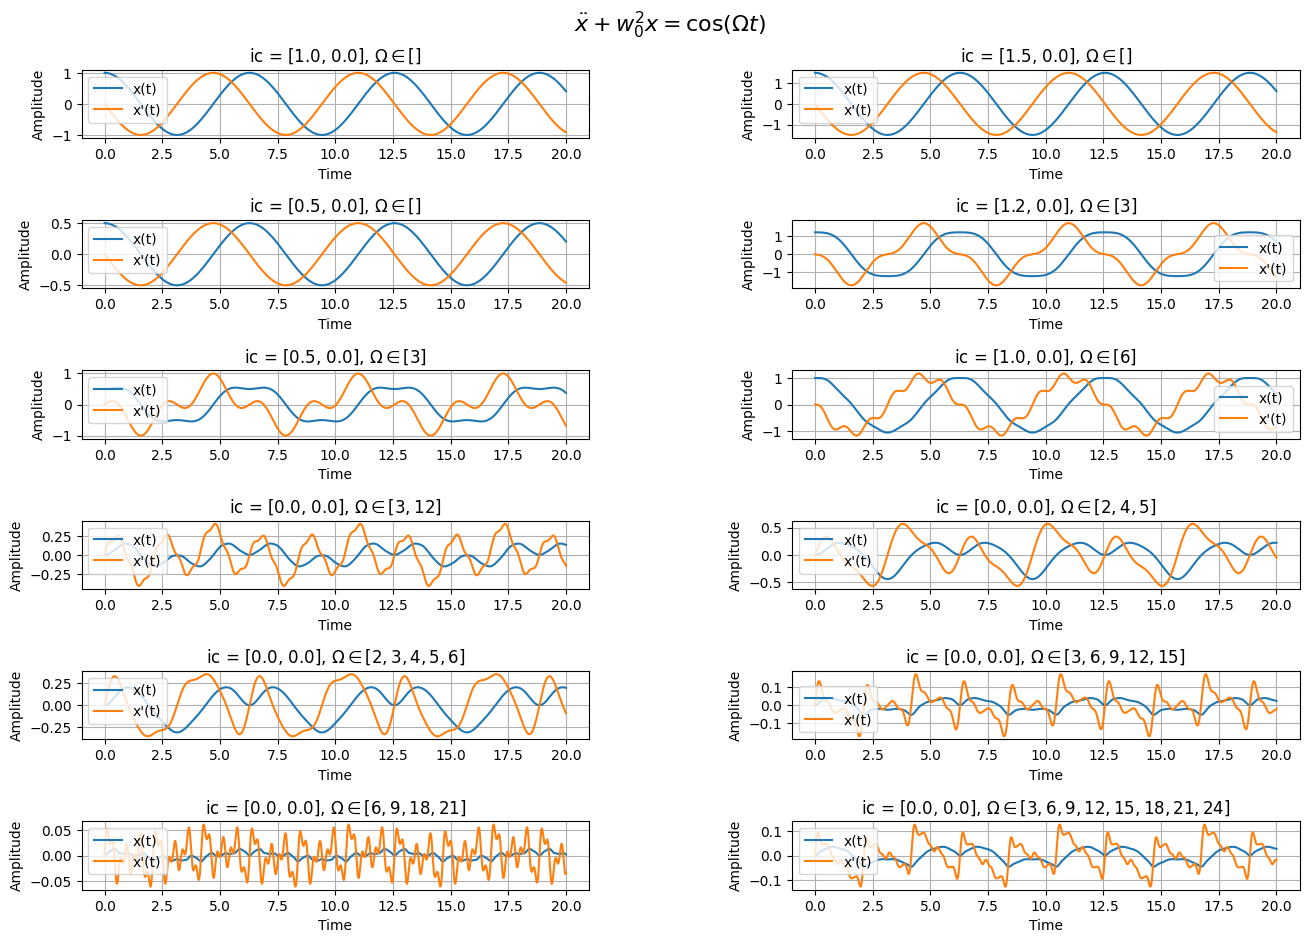

In [ ]:
# returns 2D linear equation functions
linear_equation_functions_np = [equations.ode_oscillator(forcing_list_numpy[k],
                                                    w_0=w_list[k],
                                                    epsilon=0, numpy=True)
                                                    for k in range(k)]

# solves the 2D linear equation functions
title_list = [rf"ic = {ic_python_list[i]}, $\Omega \in {forcing_freq[i]}$"
              for i in range(k)]

linear_solution_list = [numerical.solve_ode_equation(linear_equation_functions_np[index], t_span, t_eval, ic_python_list[index]) for index in range(k)]

# visualize the solutions of the training equations
numerical.plot_multiple_ode_solutions(linear_solution_list,
                                       t_eval, titles=title_list,
                                       suptitle=r"$\ddot{x} + w^2_0 x = \cos(\Omega t)$", hspace = 1.2)

## Model Configuration

In [ ]:
use_sine, use_fourier, n_frequencies, scale, bias = conf["use_sine"], conf["use_fourier"], conf["n_frequencies"], conf["scale"], conf["bias"]
hidden_layers, num_iter, learning_rate = conf["hidden_layers"], conf["num_iter"], conf["lr"]
step_size, gamma, method = conf["step_size"], conf["gamma"], conf["method"]
ode_weight, ic_weight = conf["w_ode"], conf["w_ic"]


# define model
pinn = model.Multihead_model_fourier(k, use_sine=use_sine, use_fourier=use_fourier, n_frequencies=n_frequencies,
                                      scale=scale, bias=bias, HIDDEN_LAYERS=hidden_layers)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pinn.to(dev)

Multihead_model_fourier(
  (fourier): FourierFeatures()
  (linear1): SineLayer(
    (linear): Linear(in_features=32, out_features=256, bias=True)
  )
  (linear2): SineLayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-11): 12 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
every=100
save_epoch=100
optimizer=torch.optim.Adam(pinn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Solve numerically the linear equations

## Train Neural Network on Linear version

In [ ]:
equation_functions = []
for i in range(k):
    equation_functions.append(equations.equation_oscillator(w_0=w_list[i], epsilon=0))

In [11]:
loss_trace, ode_trace, ic_trace, result_trace = training.train(model=pinn, optimizer=optimizer, num_iter=num_iter, equation_functions=equation_functions,
                                                      initial_condition_functions=ic_list, forcing_functions=forcing_list_torch,
                                                      N=N, t_span=t_span, every=every, save_epoch=save_epoch, ode_weight=ode_weight,
                                                      ic_weight=ic_weight, scheduler=scheduler, method=method)

  0%|          | 0/15000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### View results and save

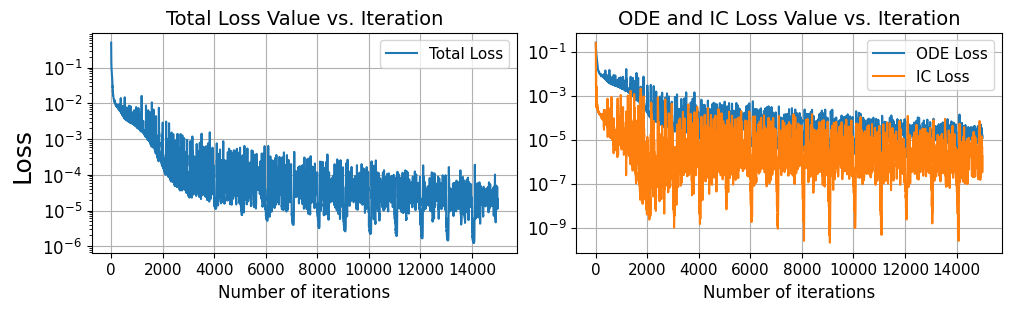

: 

: 

: 

: 

: 

: 

: 

In [ ]:
training.plot_loss(loss_trace, ode_trace, ic_trace, path=None)

In [ ]:
stop

In [ ]:
# compute the NN solutions
pinn.eval()
model.to('cpu')
NN_solution, _ = pinn(t_eval)
NN_solution = NN_solution.detach().numpy()

torch.save(pinn.state_dict(), f"model_{conf["experiment"]}.pth")

: 

: 

: 

: 

: 

: 

: 

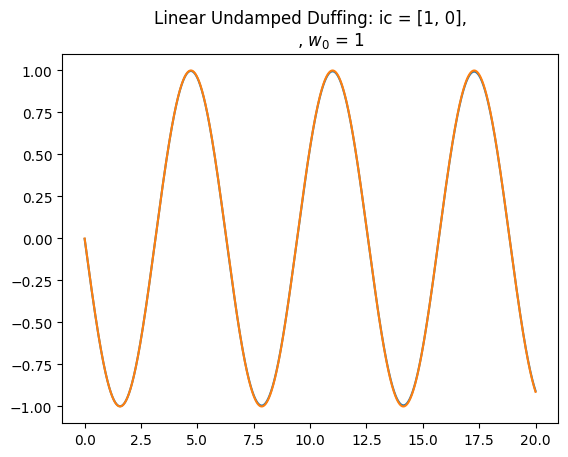

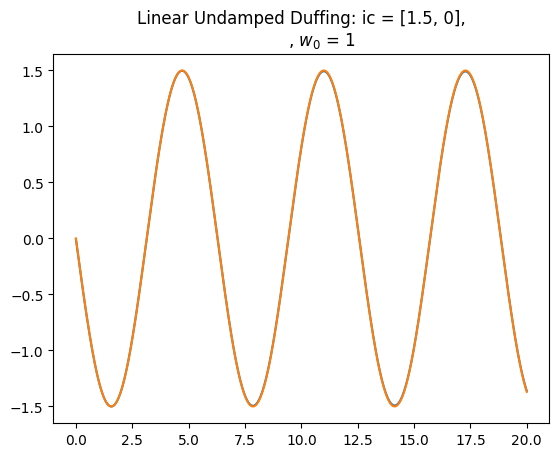

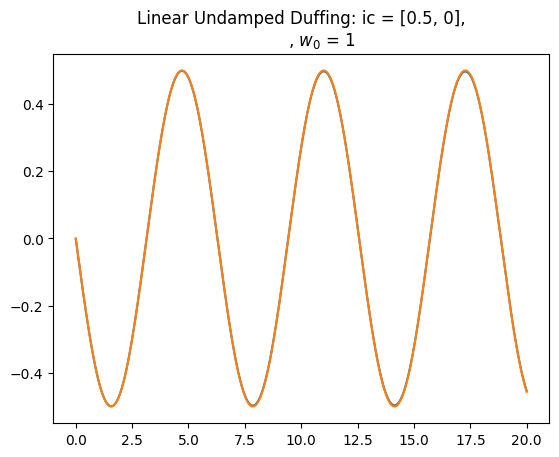

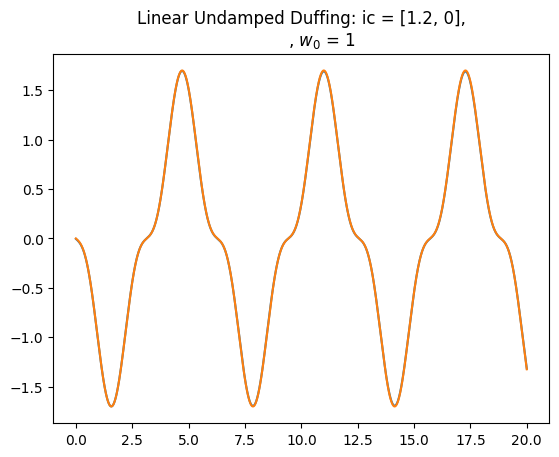

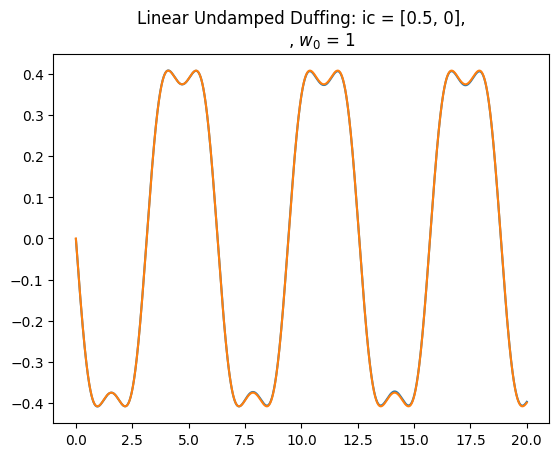

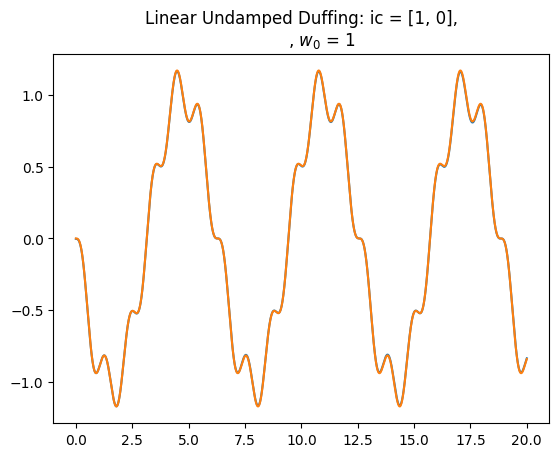

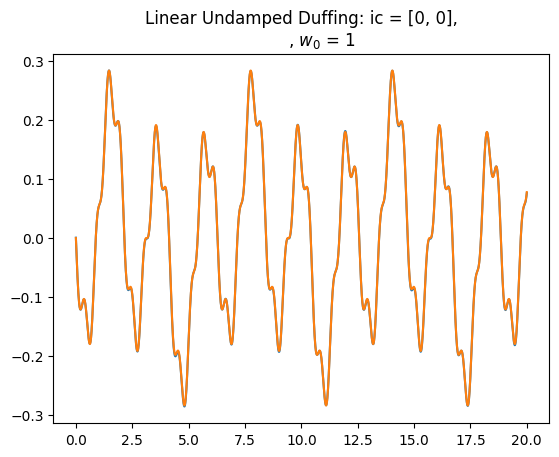

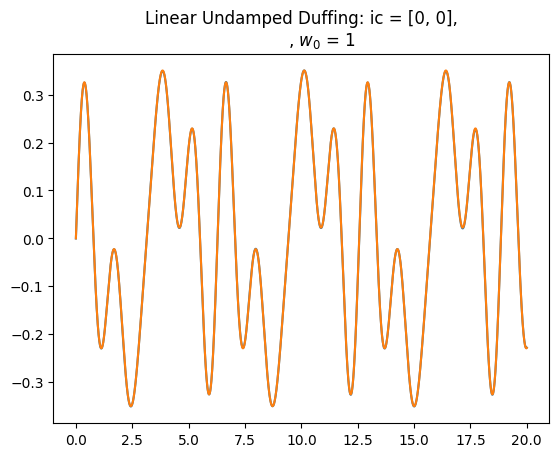

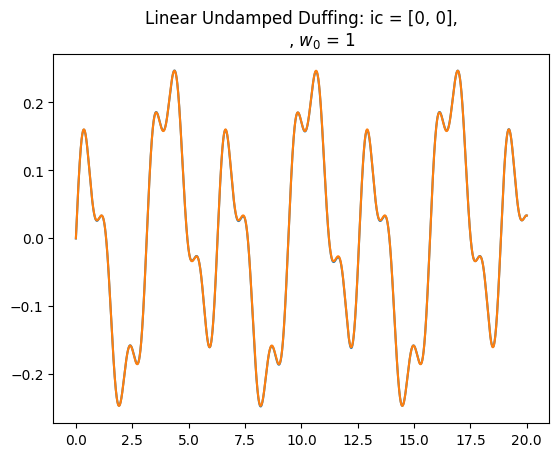

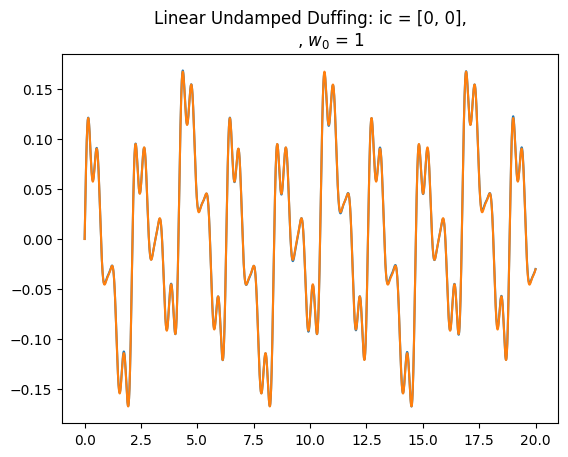

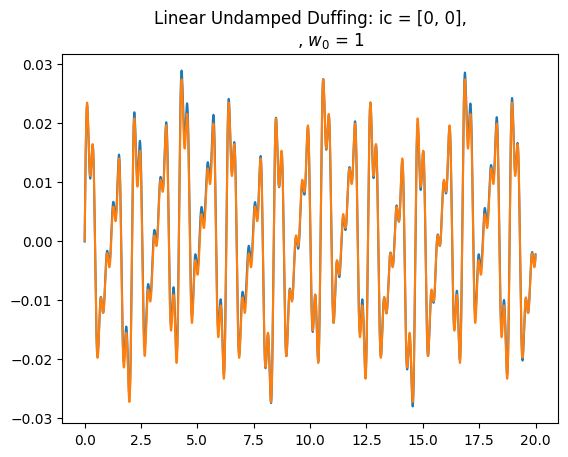

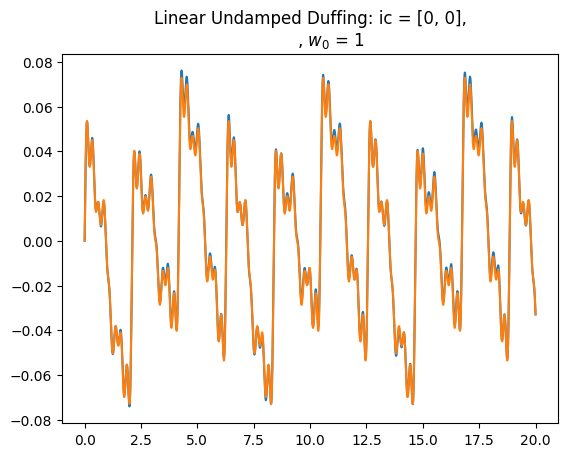

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(k, 2, figsize=(10, 3 * k), sharex=True)

for index in range(k):
    # Left column: function comparison
    axes[index, 0].plot(t_eval, NN_solution[index][:, 0], label="x(0) PINN", color="blue")
    axes[index, 0].plot(t_eval, linear_solution_list[index][0], label="x(0) RK45", color="orange", linestyle="--")
    axes[index, 0].set_title(f"{title_list[index]} - Function")
    axes[index, 0].legend()
    axes[index, 0].grid(True)

    # Right column: derivative comparison
    axes[index, 1].plot(t_eval, NN_solution[index][:, 1], label="x'(0) PINN", color="green")
    axes[index, 1].plot(t_eval, linear_solution_list[index][1], label="x'(0) RK45", color="red", linestyle="--")
    axes[index, 1].set_title(f"{title_list[index]} - Derivative")
    axes[index, 1].legend()
    axes[index, 1].grid(True)

plt.tight_layout()
plt.show()
